# Merge, Clean, Check, and Model Fine Images (new Aquasat) used for Prediction 2000-2022

In [1]:
#module imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob

os.chdir('/nas/cee-water/cjgleason/ellie/SNiP/RFmodel/CONUS/LS2/')

In [2]:
file_list = glob.glob(os.path.join('LS2_data', '*.csv'))
dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
print(dataframe.columns.values.tolist())

['SiteID', 'date', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa', 'dswe', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'qa_sd', 'dswe_sd', 'hillshade', 'hillshadow', 'hillshadow_sd', 'azimuth', 'zenith', 'pixelCount', 'elevation']


In [3]:
#Drop na, synch column names if needed, and remove negative band values, average same-day reflectances
df=dataframe.dropna(subset='blue')
df = df.drop_duplicates(subset = ['SiteID', 'date']) #groupby(['SiteID', 'date']).mean().reset_index()
df = df[(df.red > 0) & (df.red < 4000) & (df.nir > 0) & (df.blue > 0) & (df.green > 0) & (df.swir1 > 0) & (df.swir2 > 0) & (df.nir > 0)]
print(df.shape[0])
print(df.columns.values.tolist())
print(df.SiteID.unique().shape[0])

989000
['SiteID', 'date', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa', 'dswe', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'qa_sd', 'dswe_sd', 'hillshade', 'hillshadow', 'hillshadow_sd', 'azimuth', 'zenith', 'pixelCount', 'elevation']
1205


In [4]:
print(df.head())

          SiteID                 date                sceneID        blue  \
0  USGS-06930800  2000-01-10T00:00:00  LE70250342000010GNC01  244.000000   
1  USGS-06930800  2000-02-20T00:00:00  LE70240342000051EDC00  420.363636   
2  USGS-06930800  2000-02-27T00:00:00  LE70250342000058EDC00  290.656046   
3  USGS-06930800  2000-03-07T00:00:00  LE70240342000067EDC00  466.000000   
4  USGS-06930800  2000-03-23T00:00:00  LE70240342000083EDC00  450.000000   

   green         red         nir       swir1  swir2      qa  ...    swir2_sd  \
0  312.0  242.000000  213.000000  162.000000  128.0  5504.0  ...   71.856665   
1  485.0  378.413119  286.000000  186.345607  128.0  5504.0  ...  113.822432   
2  382.0  322.818182  236.736568  175.000000  121.0  5504.0  ...   86.620654   
3  533.0  446.000000  401.000000  278.000000  174.0  5504.0  ...  100.838625   
4  539.0  428.800000  444.000000  277.000000  211.0  5504.0  ...   89.335234   

      qa_sd   dswe_sd  hillshade  hillshadow  hillshadow_sd   

In [5]:
sent =  df.sceneID[df.sceneID.str.startswith('L2')].tolist()
print('The # of sent images used is: ' + str(len(sent)))

land =  list(filter(lambda x: not x.startswith('L2'), df.sceneID))
print('The # of Landsat images used is: ' + str(len(land)))

The # of sent images used is: 137256
The # of Landsat images used is: 851744


In [6]:
# Define the function to apply to the new 'sat' column
def get_sat(satID):
    if satID.startswith('LT5'):
        return int(5.0)
    elif satID.startswith('LE7'):
        return int(7.0)
    elif satID.startswith('LC8'):
        return int(8.0)
    elif satID.startswith('LC9'):
        return int(9.0)
    elif satID.startswith('L2A'):
        return int(2.0)
    else:
        return 'Other'

# Create a new column 'Region' based on the 'City' column
df['sat'] = df['sceneID'].apply(lambda x: get_sat(x))
print(df.columns.values.tolist())


['SiteID', 'date', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa', 'dswe', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'qa_sd', 'dswe_sd', 'hillshade', 'hillshadow', 'hillshadow_sd', 'azimuth', 'zenith', 'pixelCount', 'elevation', 'sat']


In [7]:
#Add band ratios
df = df.assign(NR = df['nir']/df['red'],
                BR = df['blue']/df['red'],
                GR = df['green']/df['red'],
                SR = df['swir1']/df['red'],
                BG = df['blue']/df['green'],
                RG = df['red']/df['green'],
                NG = df['nir']/df['green'],
                SG = df['swir1']/df['green'],
                BN = df['blue']/df['nir'],
                GN = df['green']/df['nir'],
                RN = df['red']/df['nir'],
                SN = df['swir1']/df['nir'],
                BS = df['blue']/df['swir1'],
                GS = df['green']/df['swir1'],
                RS = df['red']/df['swir1'],
                NS = df['nir']/df['swir1'],
                R_GN = df['red']/ (df['green'] + df['nir']),
                R_GB = df['red']/ (df['green'] + df['blue']),
                R_GS = df['red']/ (df['green'] + df['swir1']),
                R_BN = df['red']/ (df['blue'] + df['nir']),
                R_BS = df['red']/ (df['blue'] + df['swir1']),
                R_NS = df['red']/ (df['nir'] + df['swir1']),
                G_BR = df['green']/ (df['blue'] + df['red']),
                G_BN = df['green'] / (df['blue'] + df['nir']),
                G_BS = df['green'] / (df['blue'] + df['swir1']),
                G_RN = df['green'] / (df['red'] + df['nir']),
                G_RB = df['green'] / (df['red'] + df['blue']),
                G_NS = df['green'] / (df['nir'] + df['swir1']),
                B_RG = df['blue'] / (df['red'] + df['green']),
                B_RN = df['blue'] / (df['red'] + df['nir']),
                B_RS = df['blue'] / (df['red'] + df['swir1']),
                B_GN = df['blue'] / (df['green'] + df['nir']),
                B_GS = df['blue'] / (df['green'] + df['swir1']),
                B_NS = df['blue'] / (df['nir'] + df['swir1']),
                N_RG = df['nir'] / (df['red'] + df['green']),
                N_RB = df['nir'] / (df['red'] + df['blue']),
                N_RS = df['nir'] / (df['red'] + df['swir1']),
                N_GB = df['nir'] / (df['green'] + df['blue']),
                N_GS = df['nir'] / (df['green'] + df['swir1']),
                N_BS = df['nir'] / (df['blue']  + df['swir1']),
                
                GR2 = (df['green'] + df['red']) / 2,
                GN2 = (df['green'] + df['nir']) / 2,
                RN2 = (df['red'] + df['nir']) / 2,
               
                #blooms
                BR_G = (df['blue'] - df['red']) / df['green'],
                NS_NR = (df['nir'] - df['swir1']) / (df['red'] - df['swir1']),
                fai = df['nir'] - (df['red'] + (df['swir1']-df['red'])*((830-660)/(1650-660))),
                # fai = (nir - red) + (red -swir) * (830-660)/(1648-660)
                N_S= df['nir'] - df['swir1'],
                N_R = df['nir']- df['red'],
                #
                ndvi = ((df['nir']-df['red'])/(df['nir']+df['red'])),
                ndwi = ((df['green']- df['swir1'])/(df['green'] + df['swir1'])),
                ndssi = ((df['blue'] - df['nir'])/ (df['blue'] + df['nir'])),
                gn_gn= ((df['green']- df['nir'])/ (df['green'] + df['nir'])),
                Matchup = 'LS2',
                TZID = 'UTC')


In [8]:
#Matchups
#bring in WQP cleaned data

file_list = glob.glob(os.path.join('/nas/cee-water/cjgleason/ellie/SNiP/RFmodel/CONUS/WQP/WQP_notAquasat', '*.csv'))
dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
print(dataframe.columns.values.tolist())


/scratch/ceewater-cpu001/7224047/ipykernel_2068193/2926903214.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
/scratch/ceewater-cpu001/7224047/ipykernel_2068193/2926903214.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
/scratch/ceewater-cpu001/7224047/ipykernel_2068193/2926903214.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
/scratch/ceewater-cpu001/7224047/ipykernel_2068193/2926903214.py:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.concat(map(pd.read_csv, file_list), ignore_index=True)
/scratch/ceewater-cpu001/7224047/ipykern

['date', 'parameter', 'SiteID', 'huc', 'org', 'org_id', 'time', 'sample_method', 'analytical_method', 'particle_size', 'date_time', 'media', 'fraction', 'status', 'hydroCondition', 'hydroEvent', 'lat', 'long', 'datum', 'parameter_name', 'value', 'units', 'sample_depth', 'sample_depth_unit']


In [9]:
df.iloc[:, []]

""
0
1
2
3
4
...
1277810
1277811
1277812
1277813


In [10]:
#Clean data
hucs = dataframe
hucs['tss'] = hucs['value']
print(hucs.columns.values.tolist())
print(len(hucs.index))
print(hucs.tss.describe())


['date', 'parameter', 'SiteID', 'huc', 'org', 'org_id', 'time', 'sample_method', 'analytical_method', 'particle_size', 'date_time', 'media', 'fraction', 'status', 'hydroCondition', 'hydroEvent', 'lat', 'long', 'datum', 'parameter_name', 'value', 'units', 'sample_depth', 'sample_depth_unit', 'tss']
1441879
count    1.441879e+06
mean     1.820071e+02
std      6.859660e+02
min      1.004000e-02
25%      7.000000e+00
50%      2.350000e+01
75%      8.800000e+01
max      9.999000e+03
Name: tss, dtype: float64


1276264


<Axes: xlabel='tss', ylabel='Count'>

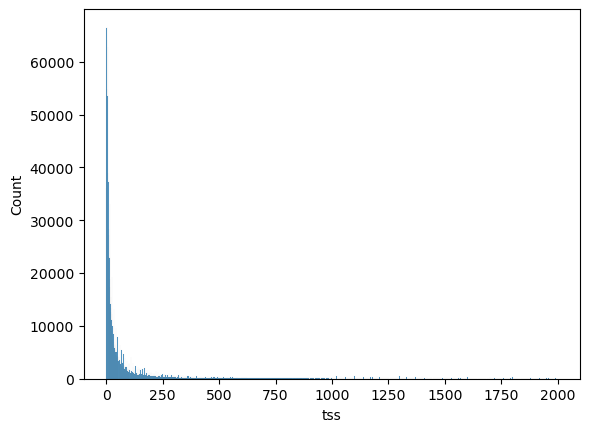

In [11]:
#HUCS EXPLORE

hucDates = hucs[hucs['date'] > '1984-01-01']
hucUnits = hucDates[hucDates['units'] == 'mg/l']
hucTSS = hucUnits[hucUnits['tss'] < 2000]
print(hucTSS.shape[0])
#print(site)
#print(hucs.sort_values(by = 'date'))
sns.histplot(data=hucTSS, x="tss")

In [12]:
#Merge data +/- 1 day
#sort the dataframes

df = df.sort_values(by = 'date')
hucs = hucs[['tss', 'parameter', 'units', 'SiteID', 'particle_size', 'time', 'date', 'hydroCondition', 
             'hydroEvent', 'huc','sample_method', 'analytical_method']].sort_values(by = 'date')
hucs['date'] = pd.to_datetime(hucs['date'])
df['date'] = pd.to_datetime(df['date'])

finePred_tss = pd.merge_asof(hucs, df, on = 'date', by ='SiteID',
                                 tolerance=pd.Timedelta(1, "d"),
                                 allow_exact_matches=True).dropna(subset = 'blue')

finePred_tss['tss_log'] = np.log(finePred_tss['tss'])
finePred_tss['R_GB_log'] = np.log(finePred_tss['R_GB'])
finePred_tss['B_RG_log'] = np.log10(finePred_tss['B_RG'])

# print the variable
#print(finePred_tss.head())

#get siteID's
finePredSites = list(finePred_tss.SiteID.unique())

print(len(finePred_tss.index))
print(finePred_tss.columns.values.tolist())

18230
['tss', 'parameter', 'units', 'SiteID', 'particle_size', 'time', 'date', 'hydroCondition', 'hydroEvent', 'huc', 'sample_method', 'analytical_method', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa', 'dswe', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'qa_sd', 'dswe_sd', 'hillshade', 'hillshadow', 'hillshadow_sd', 'azimuth', 'zenith', 'pixelCount', 'elevation', 'sat', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'TZID', 'tss_log', 'R_GB_log', 'B_RG_log']


In [13]:
#Further munging and adding useful columns for visualization
finePred_tss = finePred_tss.drop_duplicates(subset=['SiteID', 'date', 'tss'])
datetime_str = finePred_tss['date'].dt.strftime('%Y-%m-%d') + ' ' + finePred_tss['time']
finePred_tss['date_unity'] = pd.to_datetime(datetime_str).dt.strftime('%Y-%m-%d %H:%M:%S')
finePred_tss['year'] = pd.to_datetime(finePred_tss['date']).dt.year
finePred_tss['month'] = pd.to_datetime(finePred_tss['date']).dt.month
finePred_tss['date'] = pd.to_datetime(finePred_tss['date'], format = '%Y-%m-%d')


#finePred_tss = finePred_tss[finePred_tss['date_time'] > '2000-01-01 00:00:00']
print(finePred_tss.columns.values.tolist())
print(finePred_tss.tss.describe())
print(finePred_tss.SiteID.nunique())

['tss', 'parameter', 'units', 'SiteID', 'particle_size', 'time', 'date', 'hydroCondition', 'hydroEvent', 'huc', 'sample_method', 'analytical_method', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa', 'dswe', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'qa_sd', 'dswe_sd', 'hillshade', 'hillshadow', 'hillshadow_sd', 'azimuth', 'zenith', 'pixelCount', 'elevation', 'sat', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'TZID', 'tss_log', 'R_GB_log', 'B_RG_log', 'date_unity', 'year', 'month']
count    18230.000000
mean       206.644994
std        646.471020
min          0.011070
25%         11.625000
50%         52

In [ ]:
#finePred_tss = finePred_tss.groupby("SiteID").filter(lambda x: len(x) > 10)

# plot = sns.scatterplot(data=finePred_tss, x="red", y="tss", hue="SiteID")
# plt.legend(fontsize='3')

# sns.move_legend(plot, "upper left", bbox_to_anchor=(1.05, 1))
#plot.set(title='Additional hucsFine Image TSS vs Red Reflectance')

In [ ]:
# finePred_tss_5 = finePred_tss.groupby("SiteID").filter(lambda x: len(x) > 5)

# plot = sns.lmplot(data=finePred_tss_5, x="red", y="tss", 
#                        legend = 'brief', hue="SiteID")
# plt.legend(fontsize='6')
# sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
# plot

# Combine with Aquasat

In [14]:
#bring in Aquasat

aquahucs = pd.read_csv(r'/nas/cee-water/cjgleason/ellie/SNiP/Aquasat/aquasat_stream_tss.csv')
#print(aquahucs)
print(len(aquahucs.index))
aquahucs['date'] = pd.to_datetime(aquahucs['date']).dt.strftime('%Y-%m-%d')
aquahucs['date_unity'] = pd.to_datetime(aquahucs['date_unity'], utc=True).dt.strftime('%Y-%m-%d %H:%M:%S')
print(aquahucs.SiteID.nunique())
print(aquahucs.date_unity.head())
print(aquahucs.columns.values.tolist())


/scratch/ceewater-cpu001/7224047/ipykernel_2068193/3331344604.py:3: DtypeWarning: Columns (97,99,100,101,102,103,104,105,106,107,108,109,110,111,113) have mixed types. Specify dtype option on import or set low_memory=False.
  aquahucs = pd.read_csv(r'/nas/cee-water/cjgleason/ellie/SNiP/Aquasat/aquasat_stream_tss.csv')


88597
7520
0    1990-04-19 12:30:00
1    1990-04-19 12:30:00
2    1988-04-12 12:00:00
3    1989-10-10 17:00:00
4    1986-08-05 16:45:00
Name: date_unity, dtype: object
['Unnamed: 0', 'system.index', 'SiteID', 'blue', 'blue_sd', 'date_unity', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', '.geo', 'endtime', 'date', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'lat', 'long', 'TZID', 'date_utc', 'clouds', 'time', 'landsat_id', 'timediff', 'pwater', 'type', 'id', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'parameter', 'h

In [15]:
aquahucs = aquahucs.drop_duplicates(subset=['SiteID', 'date', 'tss'])
print(len(aquahucs.index))
#aquahucs.columns = aquahucs.columns.str.replace("[.]", "_")
#aquahucs.to_csv(r'aquasat_hucs_ratio.csv')

aquahucs['Matchup'] = 'AquaSat'
aquahucs['sceneID'] = aquahucs['landsat_id']
aquahucs['tss_log'] = np.log(aquahucs['tss'])
aquahucs['R_GB_log'] = np.log(aquahucs['R_GB'])
aquahucs['B_RG_log'] = np.log(aquahucs['B_RG'])

aquahucs['year'] = pd.to_datetime(aquahucs['date']).dt.year
aquahucs['month'] = pd.to_datetime(aquahucs['date']).dt.month
#aquahucs = aquahucs[aquahucs['date_utc'] > '2000-01-01T00:00:00Z']
#aquahucs = aquahucs.groupby("SiteID")#.filter(lambda x: len(x) > 5)
print(aquahucs.columns.values.tolist())

#get siteID's
aquaSites = list(aquahucs.SiteID.unique())


# plot = sns.scatterplot(data=aquahucs, x="year", y="tss", 
#                        legend = 'brief', hue="SiteID")
# plt.legend(fontsize='6')
# sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
# plot.set(title='Aquasat hucs TSS vs Red Reflectance')

83886
['Unnamed: 0', 'system.index', 'SiteID', 'blue', 'blue_sd', 'date_unity', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', '.geo', 'endtime', 'date', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'lat', 'long', 'TZID', 'date_utc', 'clouds', 'time', 'landsat_id', 'timediff', 'pwater', 'type', 'id', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'parameter', 'huc', 'org', 'org_id', 'sample_method', 'analytical_method', 'particle_size', 'media', 'fraction', 'status', 'hydroCondition', 'hydroEvent', 'datum', 'parameter_na

/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
#Check to make sure all matchup SiteIDs are actually in AquaSat
huc_aquaSites = finePred_tss[finePred_tss['SiteID'].isin(aquaSites)]
print(huc_aquaSites.SiteID.nunique())
print(huc_aquaSites.shape[0])

aqua_hucSites = aquahucs[aquahucs['SiteID'].isin(finePredSites)]
print(aqua_hucSites.SiteID.nunique())
print(aqua_hucSites.shape[0])

1074
18230
1074
26200


In [17]:
#For CSV
aquaFhucs_csv = pd.concat([aquahucs, huc_aquaSites], axis=0).drop_duplicates(subset=['SiteID', 'date', 'tss']).reset_index()
print(aquaFhucs_csv.columns.values.tolist())
print(len(aquaFhucs_csv.index))


['index', 'Unnamed: 0', 'system.index', 'SiteID', 'blue', 'blue_sd', 'date_unity', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', '.geo', 'endtime', 'date', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'lat', 'long', 'TZID', 'date_utc', 'clouds', 'time', 'landsat_id', 'timediff', 'pwater', 'type', 'id', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'parameter', 'huc', 'org', 'org_id', 'sample_method', 'analytical_method', 'particle_size', 'media', 'fraction', 'status', 'hydroCondition', 'hydroEvent', 'datum', 'parameter

In [18]:
import pandas as pd
import pytz
from datetime import datetime

# Define function to convert time zone to UTC based on timezone column
def convert_to_utc(date_str, timezone):
    # Parse date string into datetime object
    date_obj = datetime.fromisoformat(date_str)
    # Get timezone from timezone column
    tz = pytz.timezone(timezone)
    # Convert to UTC timezone
    utc_timezone = pytz.utc
    utc_date_obj = tz.localize(date_obj).astimezone(utc_timezone)
    # Return UTC date string
    return utc_date_obj.isoformat()

# Apply function to Timestamp and Timezone columns and create new column 'UTC'
aquaFhucs_csv['dateUTC'] = aquaFhucs_csv.apply(lambda row: convert_to_utc(row['date_unity'], row['TZID']), axis=1)

print(aquaFhucs_csv.dateUTC.head())


0    1990-04-19T12:30:00+00:00
1    1988-04-12T12:00:00+00:00
2    1989-10-10T17:00:00+00:00
3    1986-08-05T16:45:00+00:00
4    1986-06-18T23:00:00+00:00
Name: dateUTC, dtype: object


In [19]:
#Harmonize columns/dates/tz etc
aquaFhucs_csv['date'] = pd.to_datetime(aquaFhucs_csv.date).dt.date
aquaFhucs_csv = aquaFhucs_csv.drop(['Unnamed: 0', 'system.index', 'landsat_id', 'id', '.geo', 'date_unity', 'TZID'], axis =1)
aquaFhucs_csv['source'] = 'WQP'
aquaFhucs_csv['type'] = 'Stream'
aquaFhucs_csv['TZID'] = 'UTC'
aquaFhucs_csv['huc']= aquaFhucs_csv.groupby('SiteID')['huc'].fillna(method='bfill')  # use 'bfill' for backward filling
aquaFhucs_csv['path']= aquaFhucs_csv.groupby('SiteID')['path'].fillna(method='ffill')  # use 'bfill' for backward filling
aquaFhucs_csv['row']= aquaFhucs_csv.groupby('SiteID')['row'].fillna(method='ffill')  # use 'bfill' for backward filling
aquaFhucs_csv['elevation']= aquaFhucs_csv.groupby('SiteID')['elevation'].fillna(method='bfill')  # use 'bfill' for backward filling
aquaFhucs_csv['lat']= aquaFhucs_csv.groupby('SiteID')['lat'].fillna(method='ffill')  # use 'bfill' for backward filling
aquaFhucs_csv['long']= aquaFhucs_csv.groupby('SiteID')['long'].fillna(method='ffill')  # use 'bfill' for backward filling
aquaFhucs_csv['date_unity'] = pd.to_datetime(aquaFhucs_csv['dateUTC'])
aquaFhucs_csv = aquaFhucs_csv.drop(['dateUTC'], axis =1)


In [20]:
print(aquaFhucs_csv.columns.values.tolist())


['index', 'SiteID', 'blue', 'blue_sd', 'green', 'green_sd', 'nir', 'nir_sd', 'path', 'pixelCount', 'qa', 'qa_sd', 'red', 'red_sd', 'row', 'sat', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', 'endtime', 'date', 'date_only', 'chl_a', 'doc', 'p_sand', 'secchi', 'tis', 'tss', 'source', 'lat', 'long', 'date_utc', 'clouds', 'time', 'timediff', 'pwater', 'type', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'GR2', 'GN2', 'RN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'parameter', 'huc', 'org', 'org_id', 'sample_method', 'analytical_method', 'particle_size', 'media', 'fraction', 'status', 'hydroCondition', 'hydroEvent', 'datum', 'parameter_name', 'units', 'sample_depth', 'sample_depth_unit', 'sceneID', 'tss_log', 'R_G

In [19]:
aquaFhucs_csv.to_csv(r'/nas/cee-water/cjgleason/ellie/SNiP/RFmodel/CONUS/LS2/aquaLS2_conus_ratio.csv')

In [21]:
#For model
huc_aquaSites = huc_aquaSites[huc_aquaSites['units'] == 'mg/l']
aquahucs_model = aquahucs[['SiteID', 'lat', 'long', 'date', 'blue', 'blue_sd', 'sceneID', 'green', 'green_sd', 'nir', 'nir_sd', 'red', 'red_sd', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', 'tss', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'RN2', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'tss_log', 'R_GB_log', 'year', 'month']]
finePred_tss_model = huc_aquaSites[['tss', 'parameter', 'units', 'SiteID', 'hydroCondition', 'hydroEvent', 'date', 'sceneID', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'blue_sd', 'green_sd', 'red_sd', 'nir_sd', 'swir1_sd', 'swir2_sd', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'RN2', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'R_GB_log', 'tss_log', 'year', 'month']]
aquaFhucs = pd.concat([aquahucs_model, finePred_tss_model])

print(len(aquaFhucs[aquaFhucs['Matchup'] == 'LS2']))
print(len(aquaFhucs[aquaFhucs['Matchup'] == 'AquaSat']))

15515
83886


Text(0.5, 0, 'Band (Red)')

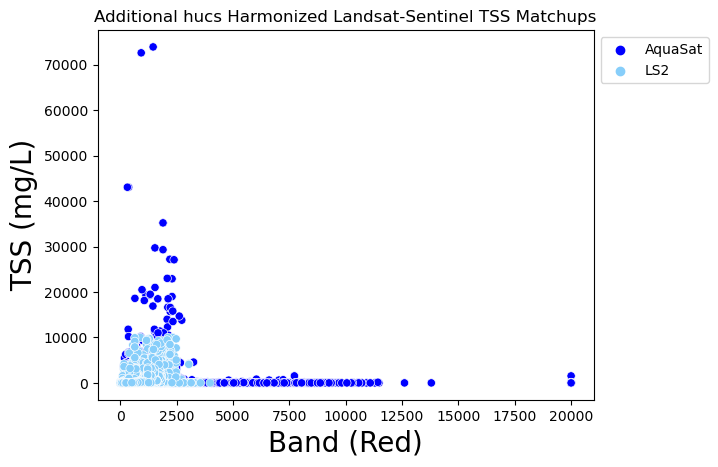

In [22]:
aquaFhucs = aquaFhucs[(aquaFhucs['red'] > 0) ] 

plot = sns.scatterplot(data=aquaFhucs, x="red", y="tss", 
                       legend = 'brief', hue = 'Matchup', palette = ['blue',  'lightskyblue'])
plot.legend(fontsize='20')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set(title='Additional hucs Harmonized Landsat-Sentinel TSS Matchups')
plt.ylabel('TSS (mg/L)', fontsize='20')
plt.xlabel('Band (Red)', fontsize='20')

# Unmatched LS2

In [23]:
#All unmatched fusion

finePred_tss_cute = finePred_tss[['SiteID', 'date']]
print(len(finePred_tss_cute.index))
#Filtered
#fusUnmatched = fusUnmatched[(fusUnmatched.R_GB < 1.0)] #& (aquaFusion.tss < 150)
LS2Unmatched = pd.merge(finePred_tss_cute, df, on =['SiteID', 'date'], how ="outer")

LS2Unmatched['Matchup'] = 'LS2 No Matchup'
print('All Site LS2 Unmatched huc:', len(LS2Unmatched.index))
print('Unmatched LS2 Sites:', len(LS2Unmatched.SiteID.unique()))

#All unmatched WQP

wqpUnmatched = pd.merge(finePred_tss_cute, hucs, on =['SiteID', 'date'], how ="outer")
wqpUnmatched['Matchup'] = 'WQP'
print('All WQP Unmatched huc:', len(wqpUnmatched.index))
wqpUnmatched_fusionSites = wqpUnmatched[wqpUnmatched['SiteID'].isin(df.SiteID.unique())]
print('Unmatched WQP Sites Current Subset:', len(wqpUnmatched_fusionSites.index))



18230
All Site LS2 Unmatched huc: 1003985
Unmatched LS2 Sites: 1205
All WQP Unmatched huc: 1475509
Unmatched WQP Sites Current Subset: 256309


In [24]:
#SAVE
LS2Unmatched.to_csv(r'/nas/cee-water/cjgleason/ellie/SNiP/RFmodel/CONUS/LS2/LS2NoMatch_1984-2023.csv', index=False)


# Model

In [26]:
import numpy as np
import pandas as pd
from numpy import mean, arange
from numpy import std
import pprint
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import plotly
import plotly.express as px
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn import ensemble, datasets, tree
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

['SiteID', 'lat', 'long', 'date', 'blue', 'blue_sd', 'sceneID', 'green', 'green_sd', 'nir', 'nir_sd', 'red', 'red_sd', 'swir1', 'swir1_sd', 'swir2', 'swir2_sd', 'tss', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 'N_GS', 'N_BS', 'RN2', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndvi', 'ndwi', 'ndssi', 'gn_gn', 'Matchup', 'tss_log', 'R_GB_log', 'year', 'month', 'parameter', 'units', 'hydroCondition', 'hydroEvent']
count    87146.000000
mean       465.513541
std        229.362964
min          0.380030
25%        317.000000
50%        426.000000
75%        566.000000
max       3881.760435
Name: blue, dtype: float64


Text(0.5, 0, 'Band (Red/(Green + Blue))')

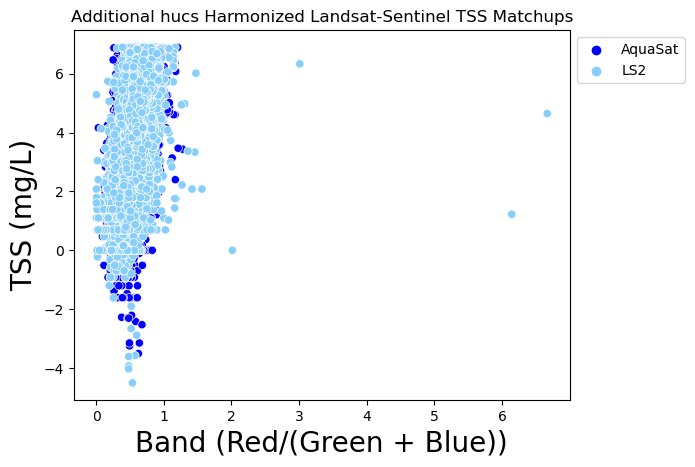

In [27]:
#Clean data
df = aquaFhucs.groupby('SiteID').filter(lambda x: len(x) > 5)
print(df.columns.values.tolist())
df = df.dropna(subset=['tss'])


df = df[(df.red > 0) & (df.nir > 0) & (df.blue > 0) & (df.green > 0) & (df.swir1 > 0) & 
        (df.swir2 > 0) & (df.red < 2500) & (df.tss < 1000)]


print(df.blue.describe())

#Generate Plot
plot = sns.scatterplot(data=df, x="R_GB", y="tss_log", 
                       legend = 'brief', hue = 'Matchup', palette = ['blue',  'lightskyblue'])
plot.legend(fontsize='20')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plot.set(title='Additional hucs Harmonized Landsat-Sentinel TSS Matchups')
plt.ylabel('TSS (mg/L)', fontsize='20')
plt.xlabel('Band (Red/(Green + Blue))', fontsize='20')

In [28]:
#define a training and testing set


df= aquahucs[['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'year', 'month', 'tss_log', 'NR', 'BR', 'GR', 'SR', 'BG', 'RG', 
              'NG', 'SG', 'BN', 'GN', 'RN', 'SN', 'BS', 'GS', 'RS', 'NS', 'R_GN', 'R_GB', 'R_GS', 'R_BN', 'R_BS', 'R_NS', 'G_BR', 
              'G_BN', 'G_BS', 'G_RN', 'G_RB', 'G_NS', 'B_RG', 'B_RN', 'B_RS', 'B_GN', 'B_GS', 'B_NS', 'N_RG', 'N_RB', 'N_RS', 'N_GB', 
              'N_GS', 'N_BS', 'GR2', 'GN2', 'BR_G', 'NS_NR', 'fai', 'N_S', 'N_R', 'ndssi', 'R_GB_log']].dropna(axis=0) #dropping na just in case here again
df = df[(df.red > 0) & (df.tss_log < 2000)]
df = df[np.isfinite(df).all(1)]

# Arrange Data into Features Matrix and Target Vector
X = df.loc[:, df.columns != 'tss_log']
y = df.loc[:, 'tss_log'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# summarize the dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#define model
model = RandomForestRegressor(bootstrap = True, oob_score= True, random_state = 42)



(66978, 57)
(16745, 57)
(66978,)
(16745,)


# Random Forest 1: No fit

Target: TSS

Input Data: 6 Bands and their ratios

In [29]:
#Quick eval raw
model.fit(X_train, y_train)
print('Trained model oob score', model.oob_score_)

prediction = model.predict(X_test)

#Metrics for Model 1 

RMSE_model = np.sqrt(mean_squared_error(y_test, prediction))

#Metrics
print('Training score', model.score(X_train, y_train))
print('RMSE', RMSE_model)
print('Testing score', model.score(X_test, y_test))

Trained model oob score 0.5468094927448641
Training score 0.9328138528696165
RMSE 0.9481812817213354
Testing score 0.5534827234173898


In [ ]:
#Feature importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
plt.rcParams.update({'font.size': 20})
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.ylabel('Band')
plt.xlabel('Importance (%)')
plt.yticks(pos, np.array(X.columns)[sorted_idx], size = 12)
plt.title('Feature Importance')
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))

import math
# y_test = math.e ** y_test
# prediction = math.e ** prediction

plt.scatter(y_test, prediction, c='crimson')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
# Calculate the absolute errors
errors = abs(prediction - y_test)
print(mean(errors))
pd.DataFrame(errors).plot(kind='bar')

In [ ]:
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
X_test_predict=pd.DataFrame(
    model.predict(X_test)).rename(
    columns={0:'predicted_tss_log'}).set_index('predicted_tss_log')
X_train_predict=pd.DataFrame(
    model.predict(X_train)).rename(
    columns={0:'predicted_tss_log'}).set_index('predicted_tss_log')
# combine the training and testing dataframes to visualize
# and compare.
RF_predict = pd.concat([X_train_predict, X_test_predict])

from sklearn.metrics import r2_score
RSquared = r2_score(y_train, X_train_predict.reset_index().values)
print('RSquared', RSquared)

# Optimizing the Random Forest

## I will optimize:

max_features

n_estimators

max_depth


In [23]:
###takes a lot of time. See results below.

from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor(bootstrap = True, oob_score= True, random_state = 42, verbose = 0)
param_grid = {
            "n_estimators" : [100, 150, 200, 300],
            "max_features" : ["1.0", "log2", "sqrt"],
            "max_depth"    : [1, 4, 7, 8, 10]
        }


grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 5, verbose =0)
grid.fit(X_train, y_train)


forest = grid.best_estimator_

grid_prediction=forest.predict(X_test)

print ('Grid best score:', grid.best_score_, 'Grid best params:', grid.best_params_)

mae_grid = mean_absolute_error(y_test, grid_prediction)
RMSE_model_grid = np.sqrt(mean_squared_error(y_test, grid_prediction))

print('MAE:', mae_grid)
print('RMSE:', RMSE_model_grid)

/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/work/efriedmann_umass_edu/.conda/envs/fusion_SNiP/lib/python3.10/si

Grid best score: 0.3863919690363738 Grid best params: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}
MAE: 21.85239185754425
RMSE: 30.565680852871274


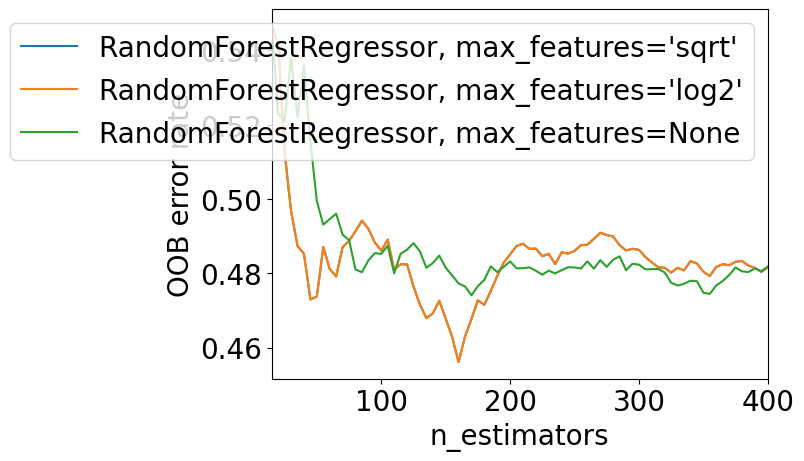

In [24]:
#Optimize RF
#OPtimize max_features and n_estimators using oob_score


#plot ensemble oob

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

RANDOM_STATE = 42

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            oob_score=True,
            verbose =0,
            max_features=3,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            max_features="log2",
            oob_score=True,
            verbose =0,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            bootstrap=True,
            warm_start=True,
            max_features=None,
            oob_score=True,
            verbose = 0,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 400

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_test, y_test)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Processed Regression Tree (depth=1)
Processed Regression Tree (depth=2)
Processed Regression Tree (depth=3)
Processed Regression Tree (depth=4)
Processed Regression Tree (depth=5)
Processed Regression Tree (depth=6)
Processed Regression Tree (depth=7)
Processed Regression Tree (depth=8)
Processed Regression Tree (depth=9)
Processed Regression Tree (depth=10)
Processed Regression Tree (depth=11)
Processed Regression Tree (depth=12)
Processed Regression Tree (depth=13)
Processed Regression Tree (depth=14)
Processed Regression Tree (depth=15)


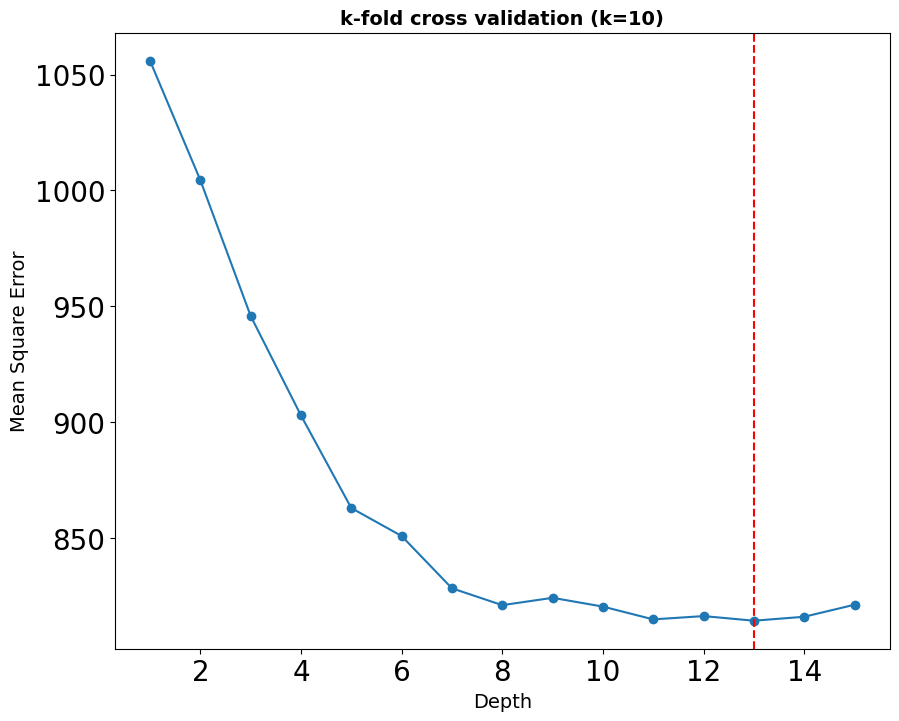

In [25]:
# Setup evaluation with 10-fold cv
k_fold = 10
dep = np.arange(1,15+1)

scores = []
for i in dep:
    cv = cross_val_score(RandomForestRegressor(random_state=42,max_depth=i), X_train, y_train,\
         cv=k_fold, scoring='neg_mean_squared_error').mean()
    scores.append(cv)
    print(f'Processed Regression Tree (depth={i})')
best = dep[np.argmin(np.array(scores)*-1)]

plt.figure(figsize=(10,8))
plt.plot(dep, np.array(scores)*-1, '-o')
plt.axvline(best, color = 'r', ls="--")
plt.xlabel('Depth',fontsize=14)
plt.ylabel('Mean Square Error',fontsize=14)
plt.title(f'k-fold cross validation (k={k_fold})',fontsize=14, fontweight='bold')
plt.show()

# Tuned Model

In [26]:
#define model
model1 = RandomForestRegressor(max_depth = 12, n_estimators = 100, max_features = 3, bootstrap = True, oob_score= True, warm_start = True, ccp_alpha = 0, min_impurity_decrease = 0)

#Quick eval raw
model1.fit(X_train, y_train)
print('Trained model oob score', 1 - model1.oob_score_)

prediction1 = model1.predict(X_test)

print('Test Score', model1.score(X_test, y_test))

#Test Error: Model 1 RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#TEST

RMSE_model1 = np.sqrt(mean_squared_error(y_test, prediction1))

#Metrics
print('Training score', model1.score(X_train, y_train))
print('RMSE', RMSE_model1)
print('Testing score', model1.score(X_test, y_test))



Trained model oob score 0.6053573627778678
Test Score 0.49394971649899355
Training score 0.9092204354210448
RMSE 30.224612790310044
Testing score 0.49394971649899355


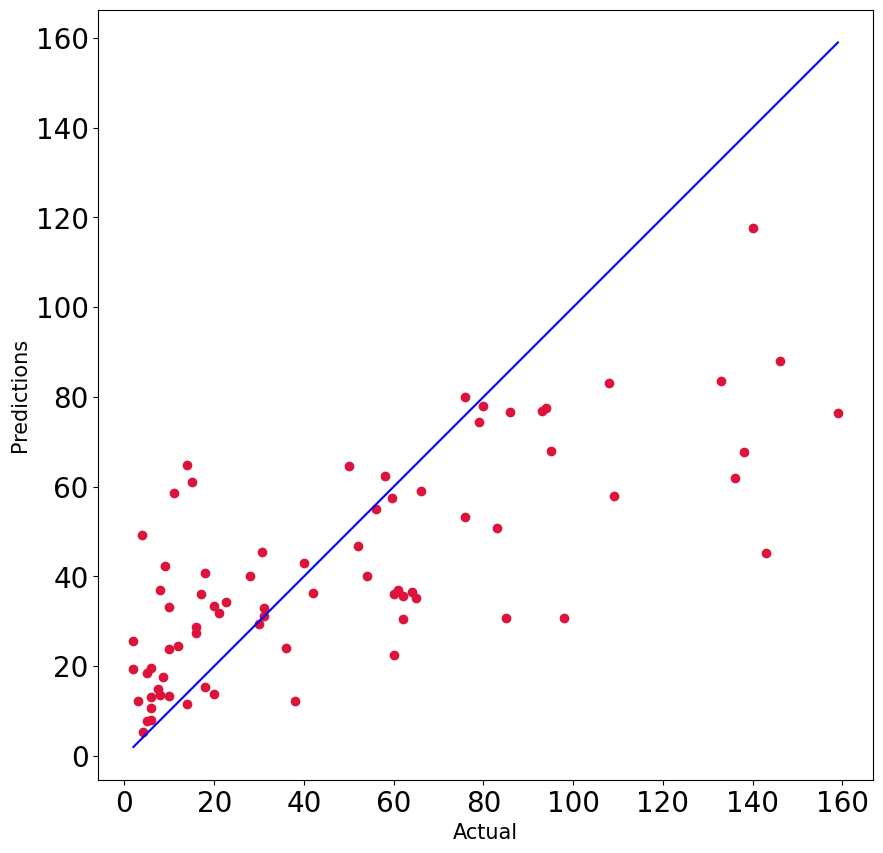

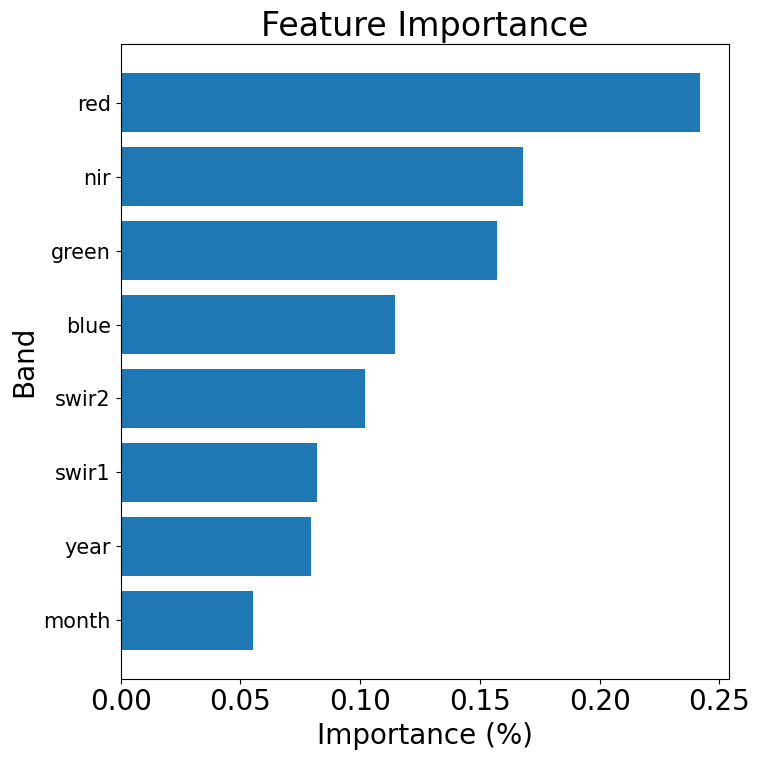

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction1, c='crimson')

p1 = max(max(prediction1), max(y_test))
p2 = min(min(prediction1), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

#Feature importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
plt.rcParams.update({'font.size': 20})
feature_importance = model1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.ylabel('Band')
plt.xlabel('Importance (%)')
plt.yticks(pos, np.array(X.columns)[sorted_idx], size = 15)
plt.title('Feature Importance')
result = permutation_importance(model1, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()


           Metric    RF1    RF2
0             MAE   7.29   7.47
1            RMSE  11.26  11.36
2       r_squared    NaN    NaN
3  Training_Score    NaN    NaN
4   Testing_Score    NaN    NaN


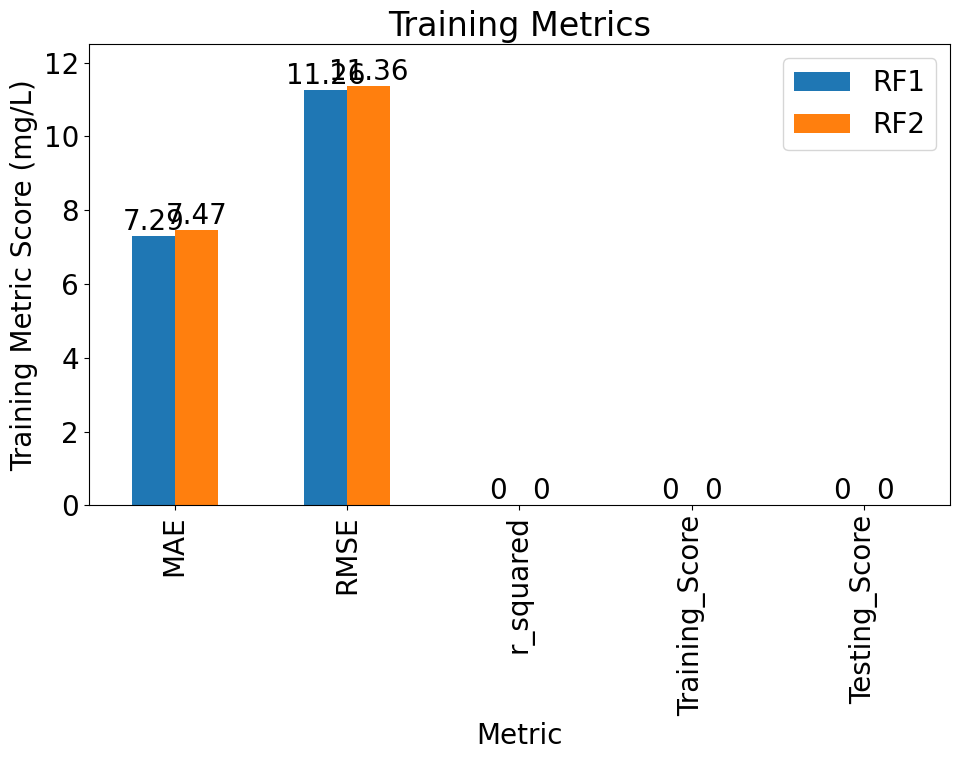

           Metric    RF1    RF2
0             MAE  21.13  21.66
1            RMSE  29.45  30.22
2       r_squared    NaN    NaN
3  Training_Score    NaN    NaN
4   Testing_Score    NaN    NaN


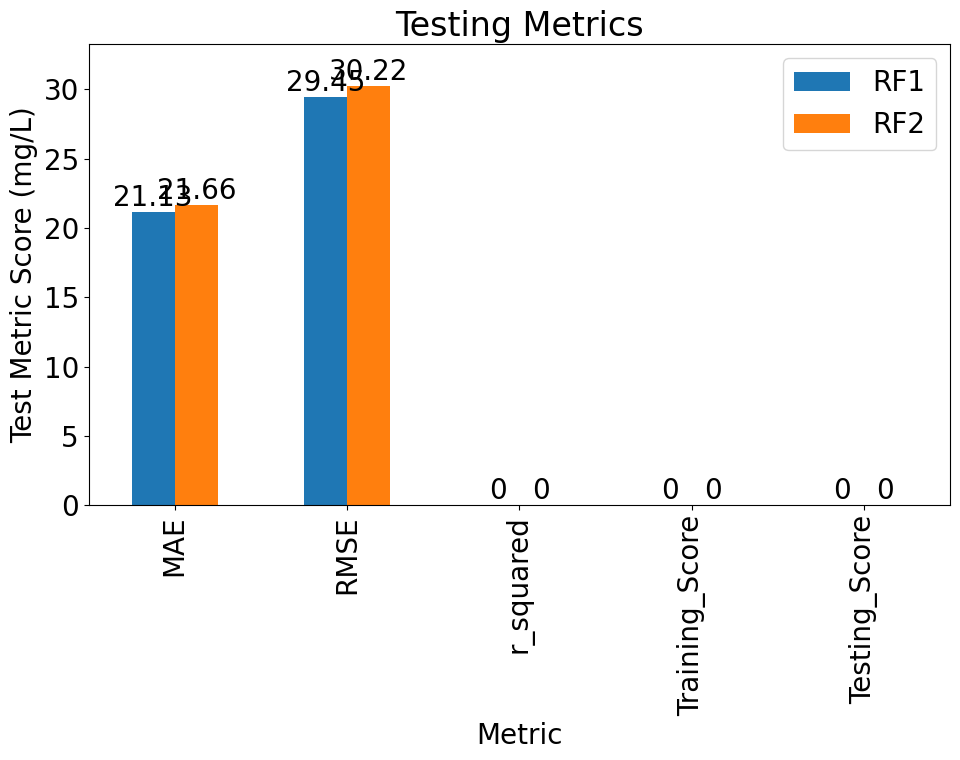

In [28]:
#Collect the test set predictions for d-h models

model_pred = model.predict(X_test)
model1_pred = model1.predict(X_test)


# Keep predictions of models d-h
model_train_pred = [model.predict(X_train),model1.predict(X_train)]

model_test_pred = [model.predict(X_test),model1.predict(X_test)]

# predicted MAE and MSE for training data

models_MAE = []
for i in model_train_pred:
    MAE = np.round(mean_absolute_error(y_train, i),2)
    models_MAE.append(MAE)

models_RMSE = []
for i in model_train_pred:
    RMSE = np.round(np.sqrt(mean_squared_error(y_train, i)),2)
    models_RMSE.append(RMSE)

    
# Plot
mod_names=['RF1', 'RF2']
metric=pd.DataFrame(['MAE','RMSE', 'r_squared', 'Training_Score', 'Testing_Score'],columns=['Metric'])
df = pd.concat([metric,pd.DataFrame([models_MAE,models_RMSE],columns=mod_names)],axis=1)

print(df.head())

ax = df.plot(x="Metric", y=mod_names, kind="bar", title = 'Training Metrics', figsize=(10,8))
# annotate
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)
plt.ylabel('Training Metric Score (mg/L)')
plt.tight_layout()
plt.show()

#Predict MAE and RMSE for test data

models_MAE_test = []
for i in model_test_pred:
    MAE = np.round(mean_absolute_error(y_test, i),2)
    models_MAE_test.append(MAE)

models_RMSE_test = []
for i in model_test_pred:
    RMSE = np.round(np.sqrt(mean_squared_error(y_test, i)),2)
    models_RMSE_test.append(RMSE)

# Plot
df = pd.concat([metric,pd.DataFrame([models_MAE_test,models_RMSE_test],columns=mod_names)],axis=1)

print(df.head())

ax = df.plot(x="Metric", y=mod_names, kind="bar", title = 'Testing Metrics', figsize=(10,8))
# annotate
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)
plt.ylabel('Test Metric Score (mg/L)')
plt.tight_layout()
plt.show()